In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-10-19 15:04:08.834051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 15:04:08.846132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729321448.859410    9714 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729321448.862649    9714 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 15:04:08.875598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 建立時間序列資料

In [2]:
# Predict 1 step ahead
# 時間序列資料的生成
def generate_time_series(m, n_seq):  # m個樣本,n_seq長度的時間序列
    freq1, freq2, offsets1, offsets2 = np.random.rand(
        4, m, 1
    )  # 4組 m*1個隨機數(0-1小數)
    time = np.linspace(0, 1, n_seq)  # 0-1，切成 n_seq
    # series => m*n_seq 二維
    series = 0.5 * np.cos((time - offsets1) * (freq1 * 10 + 10))
    series += 0.3 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(m, n_seq) - 0.5)  # 二維：m * n_seq
    return series[..., np.newaxis].astype(np.float32)  # 增加第三維度並轉成小數

In [3]:
np.random.seed(1)
n_seq = 30
n_pred = 1  # 往前預測幾步

series = generate_time_series(5000, n_seq + n_pred)  # 建立 5000筆
series.shape

(5000, 31, 1)

In [4]:
# 分割資料，不包含最后一筆，最后一筆用來做預測的
x_train, y_train = series[:3000, :n_seq], series[:3000, -1]
x_valid, y_valid = series[3000:4000, :n_seq], series[3000:4000, -1]
x_test, y_test = series[4000:, :n_seq], series[4000:, -1]

In [5]:
x_train.shape, y_train.shape

((3000, 30, 1), (3000, 1))

In [ ]:
def plot_seq(x, y, y_pred=None):
    plt.plot(x, ".-")
    n_seq = x.shape[0]  # 第一維是0，其shape=(30,1),shape[0]=30
    ahead = y.shape[0]  # shape[0]=1
    # 繪製 y 點位置
    plt.plot(np.arange(n_seq, n_seq + ahead), y, "go-", label="$y$")

    if y_pred is not None:  # 如果有預測值會另繪一條線
        plt.plot(
            np.arange(n_seq, n_seq + ahead),
            y_pred,
            "rx-",
            label="$\hat y$",
            markersize=10,
        )
    plt.hlines(0, 0, n_seq + ahead, linewidth=1)  # 水平線
    plt.axis([0, n_seq + ahead, -1, 1])  # 指定X軸與Y軸的刻度範圍
    plt.grid(True)
    plt.legend(fontsize=14)

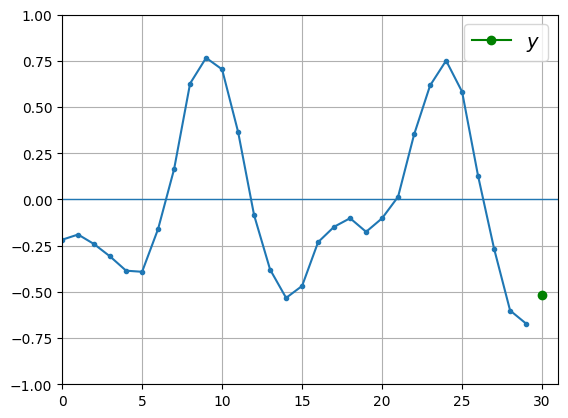

In [7]:
plot_seq(x_test[0, :, 0], y_test[0])  # 傳入第一筆資料

### SimpleRNN

In [8]:
# SimpleRNN
# 1. Build model
np.random.seed(1)
tf.random.set_seed(1)

In [9]:
model = keras.models.Sequential(
    [
        # SimpleRNN(1,...1) 包含1層(1個神經元)NN，1個特徵
        keras.layers.SimpleRNN(1, input_shape=[None, 1])  # 預設activation='tanh'(-1～1)
    ]
)
model.summary()
"""
Param ＝ (1b+1Wx輸入權重+1Wh輸出權重)*1傳回神經元 ＝ 3
"""

I0000 00:00:1729321491.780439    9714 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

'\nParam ＝ (1b+1Wx輸入權重+1Wh輸出權重)*1傳回神經元 ＝ 3\n'

In [10]:
# 2. Compile
opt = keras.optimizers.Adam(learning_rate=0.05)
# 因為 y 是連續型的數值，所以適用 mse
model.compile(loss="mse", optimizer=opt)

In [11]:
# 3. Train
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20


I0000 00:00:1729321501.269673    9934 service.cc:148] XLA service 0x564faab69b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729321501.269725    9934 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-10-19 15:05:01.306511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729321501.401301    9934 cuda_dnn.cc:529] Loaded cuDNN version 90300


59/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2013

I0000 00:00:1729321501.667366    9934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1602 - val_loss: 0.0312
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - val_loss: 0.0285
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - val_loss: 0.0286
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - val_loss: 0.0287
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - val_loss: 0.0288
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - val_loss: 0.0289
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - val_loss: 0.0290
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - val_loss: 0.0290
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 - val_loss: 0.0291
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 - val_loss: 0.0291
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 - val_loss: 0.0292
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.0292

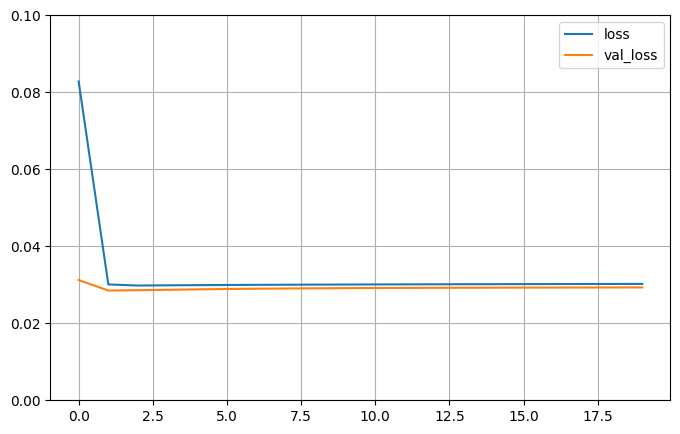

In [12]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()

In [13]:
# 4. Evaluate
model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311


0.03251655027270317

In [14]:
# 5. Predict
y_pred = model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


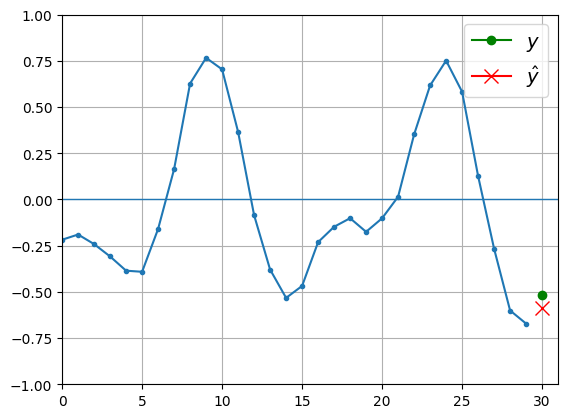

In [15]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])
# 加上預測值后，觀察綠點(y)和紅點(y_hat)的差異

### Deep RNN

In [16]:
# Deep RNN
# 1. Build Model
np.random.seed(1)
tf.random.set_seed(1)

In [17]:
model = keras.models.Sequential(
    [
        # 前二層各有20個神經元
        # 當下一層也是RNN層時，要加上return_sequences=True，才能回傳
        # 因為要記錄 y 序列送到下一層
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1),
    ]
)

/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()
"""
simple_rnn_1:440=(1 bias+1 feature+20個傳回的y)*20個神經元
simple_rnn_2:820=(1 bias+20 feature+20個傳回的y)*20個神經元
simple_rnn_3: 22=(1 bias+20 feature+1個傳回的y)*1個神經元 
"""

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

'\nsimple_rnn_1:440=(1 bias+1 feature+20個傳回的y)*20個神經元\nsimple_rnn_2:820=(1 bias+20 feature+20個傳回的y)*20個神經元\nsimple_rnn_3: 22=(1 bias+20 feature+1個傳回的y)*1個神經元 \n'

In [19]:
# 2. Compile
model.compile(loss="mse", optimizer="adam")

In [20]:
# 3. Train
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1985 - val_loss: 0.0316
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0259 - val_loss: 0.0178
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159 - val_loss: 0.0127
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - val_loss: 0.0097
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0059

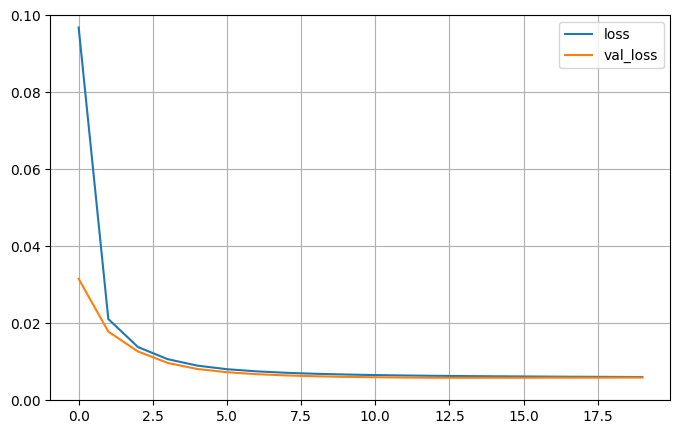

In [21]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()

In [22]:
# 4. Evaluate
model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069


0.006664968561381102

In [23]:
# 5. Predict
y_pred = model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


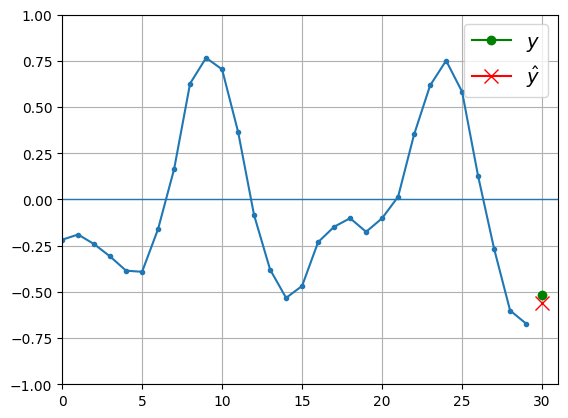

In [24]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])

### Deep RNN (dense output layer)

In [25]:
# 1. Build Model
np.random.seed(1)
tf.random.set_seed(1)

In [26]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1),
    ]
)

/home/chesterxalan/github/Classwork/Classwork-PythonDLApplicationDevelopment/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.summary()
"""
simple_rnn_4 (SimpleRNN)  440=(1+1+20)*20   
 simple_rnn_5 (SimpleRNN)  820= (1+20+20)*20 
 dense (Dense)  21 = (1+20)*1
"""

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

'\nsimple_rnn_4 (SimpleRNN)  440=(1+1+20)*20   \n simple_rnn_5 (SimpleRNN)  820= (1+20+20)*20 \n dense (Dense)  21 = (1+20)*1\n'

In [28]:
# 2. Compile
model.compile(loss="mse", optimizer="adam")

In [29]:
# 3. Train
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1301 - val_loss: 0.0169
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0096
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_l

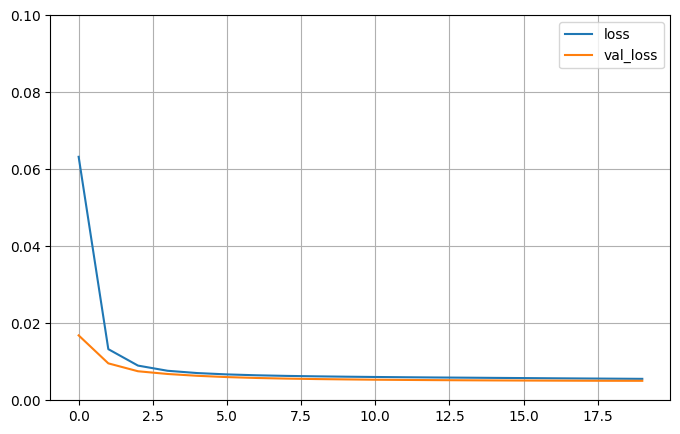

In [30]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

In [31]:
# 4. Evaluate
model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057


0.005351577885448933

In [32]:
# 5. Predict
y_pred = model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


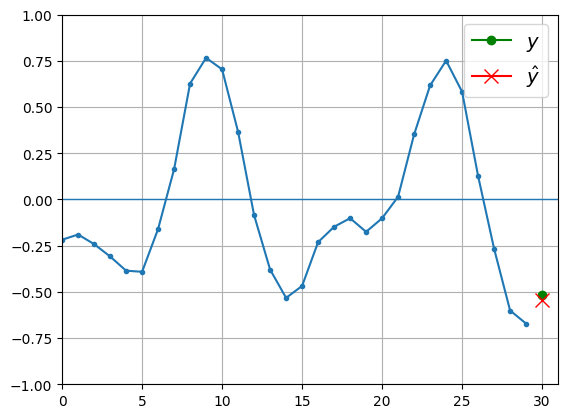

In [33]:
i = 0
plot_seq(x_test[i, :, 0], y_test[i], y_pred[i])